# Research Challenge

```{admonition} Margaret Atwood
:class: tip
Every aspect of human technology has a dark side, including the bow and arrow
```

## 🏅 Build your own model 

You have been assigned one dataset from [MatBench](https://matbench.materialsproject.org) as introduced in the [Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-lecture9-challenge). You are free to choose and tune any machine-learning model, with any Python library, but it should be appropriate for the problem. For instance, [XGBoost](https://xgboost.readthedocs.io) could be a good starting starting point to build a regression model. You can refer back to earlier notebooks and repurpose code as needed. 

You may reach the limits of computing processing power on Google Colab. Building a useful model with limited resources is a real-world skill. Using other free resources is allowed if you find an alternative service, as is running on your own computer. A model tracker such as [wandb](https://wandb.ai) could be helpful for advanced users. If you want to try a brute force approach, a library such as [Automatminer](https://hackingmaterials.lbl.gov/automatminer) may be of interest.

This notebook should be used for keeping a record of your model development, submission, and even your presentation. You are free to edit (add/remove/delete) or rearrange the cells as you see fit.

### Your details

In [139]:
# Load libraries

from matminer.datasets import get_all_dataset_info
from matminer.datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.structure.order import DensityFeatures
from matminer.featurizers.composition.element import ElementFraction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import re
import seaborn as sns
import joblib
from flaml import AutoML
import autokeras as ak
import keras
import tensorflow as tf
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.models import load_model
import shap

# Set seaborn style
sns.set_theme(style="white", palette="hls")

# Insert your values
Name = "Navraj Eari" # Replace with your name
CID = 1909382 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

This is the work of Navraj Eari [CID: 1909382]


## Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark. 

In [138]:
'''
- I have been given dataset C, which contains the structure and formation energy of 18928 perovskites.
- The goal is to predict the formation energy of perovskites using the structure of the material.
- The formation energy is a continuous variable, so this is a regression problem.
- The best performing model on the matminer leaderboard for this dataset and e_form regression task is a "Connectivity optimized Graph Network", with a mean mae of 0.0269 and rmse of 0.0554
- The top 10 best performing models on the leaderboard are all some form neural networks.
- This makes sense, and neural networks are a good choice for this problem, as they are able to capture complex non-linear relationships between the input features and the target variable.
- With a large enough dataset, and sufficent computational power and tmie, a neural network should be able to outperform other models.
'''

'\n- I have been given dataset C, which contains the structure and formation energy of 18928 perovskites.\n- The goal is to predict the formation energy of perovskites using the structure of the material.\n- The formation energy is a continuous variable, so this is a regression problem.\n- The best performing model on the matminer leaderboard for this dataset and e_form regression task is a "Connectivity optimized Graph Network", with a mean mae of 0.0269 and rmse of 0.0554\n- The top 10 best performing models on the leaderboard are all some form neural networks.\n- This makes sense, and neural networks are a good choice for this problem, as they are able to capture complex non-linear relationships between the input features and the target variable.\n- With a large enough dataset, and sufficent computational power and tmie, a neural network should be able to outperform other models.\n'

## Pre-processing dataset

- Load the dataset.
    - Since the dataset is 18928 entires, and this will take a very long time to regress on my local machine, I will only be loading 5000 entries.
- Featurise the dataset
    - I will be using 2 featurisers, and therefore creating 2 different datasets.
    - These are the ElementProperty Featureiser (Deml preset) and the ElementFraction Featuriser, which are I have chosen as they seem to perform better than the other featurises I have tried.
- Clean the dataset of any NaN values, errors, or anomalies
- Check the data distribution
    - Normailise if needed.

In [3]:
# Get dataset info from matminer

# C (GTA - Xia)
info = get_all_dataset_info("matbench_perovskites")

# Check out the info about the dataset.
print(info)

Dataset: matbench_perovskites
Description: Matbench v0.1 test dataset for predicting formation energy from crystal structure. Adapted from an original dataset generated by Castelli et al. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	e_form: Target variable. Heat of formation of the entire 5-atom perovskite cell, in eV as calculated by RPBE GGA-DFT. Note the reference state for oxygen was computed from oxygen's chemical potential in water vapor, not as oxygen molecules, to reflect the application which these perovskites were studied for.
	structure: Pymatgen Structure of the material.
Num Entries: 18928
Reference: Ivano E. Castelli, David D. Landis, Kristian S. Thygesen, Søren Dahl, Ib Chorkendorff, Thomas F. Jaramillo and Karsten W. Jacobsen (2012) New cubic perovskites for one- and two-photon water splitting using the computational materials repo

In [4]:
dfLoad = load_dataset("matbench_perovskites") # Load your dataset into a pandas DataFrame
dfLoad.head() # Check the head to see dataset

,structure,e_form
0,"[[0. 0. 0.] Rh, [1.97726555 1.97726555 1.97726...",2.16
1,"[[2.54041798 0. 0. ] Hf, [1.020...",1.52
2,"[[0.60790913 0. 0. ] Re, [2.186...",1.48
3,"[[2.83091357 0. 0. ] W, [2.6573...",1.24
4,"[[0.00518937 0. 0. ] Bi, [2.172...",0.62


In [5]:
# To reduce the dataset size (if required due to computational resources)

fast_mode = True # Since the original dataset is too large for my local machine to run the models, I will set this to True

if fast_mode:
    # Store the original DataFrame as a copy
    full_dataset_df = dfLoad.copy()
    # Create a random subset of the original DataFrame
    dfLoad = dfLoad.sample(n=5000, random_state=41)
    
dfLoad['composition'] = dfLoad.structure.apply(lambda x: x.composition ) # Extract the composition from the structure

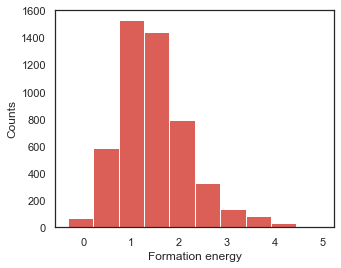

In [6]:
# Plot a histogram of values for the target variable, the formation energy

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(dfLoad['e_form'])
ax.set_xlabel('Formation energy' )
ax.set_ylabel('Counts')
plt.show()

- We see an approximately boltzmann distribution of the formation energy, with a mean around -2.5 eV.

### ElementProperty Featureiser (Deml preset)
- Class to calculate elemental property attributes.

In [7]:
# Featurise dataset

df_ElementProperties = dfLoad.copy() # Create a copy of the dataset to featurise
el_prop_featuriser = ElementProperty.from_preset(preset_name='deml') # Create the featuriser
el_prop_featuriser.set_n_jobs(1) 
df_ElementProperties = el_prop_featuriser.featurize_dataframe(df_ElementProperties, col_id='composition') # Featurise the dataset

density_featuriser = DensityFeatures() # Create the featuriser, this time for density features
density_featuriser.set_n_jobs(1)
df_ElementProperties=density_featuriser.fit_featurize_dataframe(df_ElementProperties, col_id='structure') # Featurise the dataset

df_ElementProperties.head() # Check the head to see the featurised dataset


DensityFeatures: 100%|██████████| 5000/5000 [00:06<00:00, 794.98it/s]


,structure,e_form,composition,DemlData minimum atom_num,DemlData maximum atom_num,DemlData range atom_num,DemlData mean atom_num,DemlData std_dev atom_num,DemlData minimum atom_mass,DemlData maximum atom_mass,...,DemlData mean mus_fere,DemlData std_dev mus_fere,DemlData minimum FERE correction,DemlData maximum FERE correction,DemlData range FERE correction,DemlData mean FERE correction,DemlData std_dev FERE correction,density,vpa,packing fraction
15795,"[[0.00101542 0. 0. ] Mo, [2.014...",1.08,"(Mo, W, N)",7,74,67,27.4,36.021819,14.0067,183.84000,...,-8.633582,1.039424,-0.28941,-0.200000,0.089410,-0.224802,0.046735,8.494715,12.581038,0.421699
1207,"[[0. 0. 0.] Ag, [1.98847797 1.9494882 1.94948...",0.46,"(Ag, Cr, F, O)",8,47,39,19.2,17.879224,15.9994,107.86820,...,-3.854642,2.727126,-0.11701,0.230000,0.347010,0.113358,0.152945,5.907375,11.854461,0.522748
3465,"[[0.00257973 0. 0. ] Re, [1.856...",1.80,"(Re, Co, N, O)",7,75,68,25.0,30.758919,14.0067,186.20700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.731086,9.936379,0.474456
2173,"[[0. 0. 0.] Y, [2.15268126 2.15268126 2.152681...",2.86,"(Y, Sr, N)",7,39,32,19.6,20.625920,14.0067,88.90585,...,-6.302015,3.928267,-0.20000,0.667379,0.867379,0.115985,0.521274,4.547395,15.960966,0.769257
1473,[[5.11388567e-01 1.48186573e-16 0.00000000e+00...,1.00,"(Sc, Ge, N, O)",7,32,25,15.0,11.808660,14.0067,72.64000,...,-6.109536,2.322784,-0.20000,0.489758,0.689758,0.094464,0.312437,4.732737,11.340481,0.503400


In [8]:
df_ElementProperties.describe() # Check the statistics of the featurised dataset

,e_form,DemlData minimum atom_num,DemlData maximum atom_num,DemlData range atom_num,DemlData mean atom_num,DemlData std_dev atom_num,DemlData minimum atom_mass,DemlData maximum atom_mass,DemlData range atom_mass,DemlData mean atom_mass,...,DemlData mean mus_fere,DemlData std_dev mus_fere,DemlData minimum FERE correction,DemlData maximum FERE correction,DemlData range FERE correction,DemlData mean FERE correction,DemlData std_dev FERE correction,density,vpa,packing fraction
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,5000.000000,5000.000000,5000.000000
mean,1.477892,7.050200,56.513000,49.462800,22.032760,24.318671,14.203837,137.151284,122.947447,50.562163,...,-4.970057,2.453080,-0.240185,0.395270,0.635455,0.086443,0.286558,5.925045,14.467446,0.502428
std,0.741175,1.199987,20.183431,20.005656,6.493574,10.157374,2.143520,54.142300,53.823943,16.837590,...,1.153687,0.928038,0.275645,0.195725,0.296538,0.140409,0.129451,1.937148,3.373356,0.185810
min,-0.320000,3.000000,7.000000,2.000000,5.600000,1.414214,6.941000,14.006700,3.195700,11.578960,...,-8.633582,0.027846,-1.260341,-0.200000,0.033774,-0.478526,0.017554,1.279388,7.177654,0.198185
25%,0.980000,7.000000,41.000000,34.000000,17.000000,16.533741,14.006700,92.906380,78.899680,37.476615,...,-5.778024,1.822062,-0.289410,0.230000,0.430000,-0.001328,0.207312,4.440871,12.138909,0.381639
50%,1.360000,7.000000,55.000000,47.000000,22.000000,23.209533,14.006700,132.905452,116.906052,50.315906,...,-4.853504,2.448356,-0.200000,0.353248,0.607379,0.096033,0.268883,5.763655,13.961928,0.444389
75%,1.860000,8.000000,77.000000,69.000000,26.600000,32.847290,15.999400,192.217000,176.223300,62.096695,...,-4.091534,3.057668,-0.166226,0.535501,0.762290,0.185339,0.345531,7.292790,16.129738,0.570773
max,4.980000,8.000000,83.000000,80.000000,39.200000,52.325902,15.999400,208.980400,202.039400,95.485500,...,-2.381480,5.930069,0.230000,0.725294,1.985635,0.427520,0.884524,12.039015,37.180651,1.439030


In [9]:
# Check for missing values, and drop them if any

print(df_ElementProperties.isna().sum()) 
df_ElementProperties.dropna(inplace=True)

structure                              0
e_form                                 0
composition                            0
DemlData minimum atom_num              0
DemlData maximum atom_num              0
                                    ... 
DemlData mean FERE correction       1120
DemlData std_dev FERE correction    1120
density                                0
vpa                                    0
packing fraction                       0
Length: 86, dtype: int64


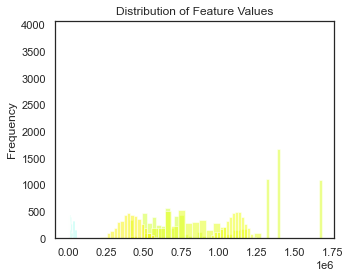

In [10]:
# Distribution of feature values

feature_columns = df_ElementProperties.columns[3:] # Extract the feature columns (excluding the first three)

# Create a unique colour for each feature
colors = [plt.cm.jet(i / float(len(feature_columns))) for i in range(len(feature_columns))]

# Plot the distribution of feature values with different colours
plt.figure(figsize=(5, 4))
for i, column in enumerate(feature_columns):
    df_ElementProperties[column].plot(kind='hist', bins=20, alpha=0.5, color=colors[i], label=column)

plt.title('Distribution of Feature Values')
plt.show()

- From the distribution of feature values, it can be seen that the features have different scales, however there are no outliers that will cause the machine learning algorithm to struggle.
- Therefore, the MAE value will be less important to us, and we can fous more on the RMSE and R2

In [11]:
# Drop columns with all zero values

all_zeros_columns = df_ElementProperties.columns[df_ElementProperties.eq(0).all()] # Extract the columns with all zero values
print(all_zeros_columns)
df_ElementProperties.drop(columns=all_zeros_columns, inplace=True) # Drop the columns with all zero values
print(df_ElementProperties.shape)

Index([], dtype='object')
(3880, 86)


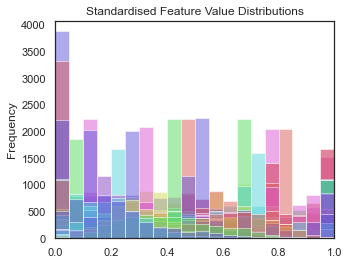

In [12]:
# After checking the distribution of the feature values, it is clear that the feature values are not standardised.
# I will standardise the feature values using the MinMaxScaler from scikit-learn.
# This will scale the feature values to be between 0 and 1, hence making the feature values comparable and interpretable for the machine learning models.

scaler = MinMaxScaler() # Create the MinMaxScaler
feature_columns = df_ElementProperties.columns[3:] # Extract the feature columns (excluding the first three)
df_ElementProperties[feature_columns] = scaler.fit_transform(df_ElementProperties[feature_columns]) # Standardise the feature values

# Plot the standardised feature distributions
plt.figure(figsize=(5, 4))
for column in feature_columns:
    df_ElementProperties[column].plot(kind='hist', bins=20, alpha=0.5, label=column, xlim=(0,1))

plt.title('Standardised Feature Value Distributions')
plt.show()

- We can see that the feature values are now standardised between 0 and 1, however, the distributions are still not normal or uniform.
- There are alot of feature values that are close to 0, and some that are close to 1.
- This could cause the machine learning models to be biased towards the feature values that are close to 0 or 1
- Ideally I would want to use the entire 18,000 dataset, and split it into training and testing sets such that the distribution of the target variable is similar in both sets.

### ElementFraction Featuriser
- Class to calculate the atomic fraction of each element in a composition.

In [13]:
# Feature dataset

df_ElementFractions = dfLoad.copy() # Create a copy of the dataset to featurise
ef = ElementFraction() # Create the featuriser
df_ElementFractions = ef.featurize_dataframe(df_ElementFractions, "composition") # Featurise the dataset

df_ElementFractions.head() # Check the head to see the featurised dataset

ElementFraction: 100%|██████████| 5000/5000 [07:41<00:00, 10.84it/s]


,structure,e_form,composition,H,He,Li,Be,B,C,N,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
15795,"[[0.00101542 0. 0. ] Mo, [2.014...",1.08,"(Mo, W, N)",0,0,0.0,0.0,0.0,0,0.6,...,0,0,0,0,0,0,0,0,0,0
1207,"[[0. 0. 0.] Ag, [1.98847797 1.9494882 1.94948...",0.46,"(Ag, Cr, F, O)",0,0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3465,"[[0.00257973 0. 0. ] Re, [1.856...",1.80,"(Re, Co, N, O)",0,0,0.0,0.0,0.0,0,0.2,...,0,0,0,0,0,0,0,0,0,0
2173,"[[0. 0. 0.] Y, [2.15268126 2.15268126 2.152681...",2.86,"(Y, Sr, N)",0,0,0.0,0.0,0.0,0,0.6,...,0,0,0,0,0,0,0,0,0,0
1473,[[5.11388567e-01 1.48186573e-16 0.00000000e+00...,1.00,"(Sc, Ge, N, O)",0,0,0.0,0.0,0.0,0,0.4,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_ElementFractions.describe() # Check the statistics of the featurised dataset

,e_form,H,He,Li,Be,B,C,N,O,F,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
count,5000.000000,5000.0,5000.0,5000.000000,5000.000000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,1.477892,0.0,0.0,0.007720,0.006760,0.007920,0.0,0.202680,0.312000,0.056720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.741175,0.0,0.0,0.038739,0.036146,0.039212,0.0,0.214499,0.180816,0.090158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-0.320000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.980000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.200000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.360000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.200000,0.400000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.860000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.400000,0.400000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,4.980000,0.0,0.0,0.400000,0.200000,0.400000,0.0,0.600000,0.600000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Check for missing values, and drop them if any

print(df_ElementFractions.isna().sum())
df_ElementFractions.dropna(inplace=True)

structure      0
e_form         0
composition    0
H              0
He             0
              ..
Es             0
Fm             0
Md             0
No             0
Lr             0
Length: 106, dtype: int64


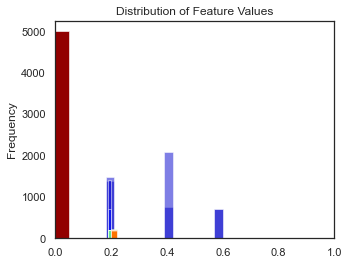

In [16]:
# Distribution of feature values

feature_columns = df_ElementFractions.columns[3:] # Extract the feature columns (excluding the first three)

# Create a unique colour for each feature
colors = [plt.cm.jet(i / float(len(feature_columns))) for i in range(len(feature_columns))]

# Plot the distribution of feature values with different colours
plt.figure(figsize=(5, 4))
for i, column in enumerate(feature_columns):
    df_ElementFractions[column].plot(kind='hist', bins=20, alpha=0.5, color=colors[i], label=column, xlim=(0,1))

plt.title('Distribution of Feature Values')
plt.show()

- From the distribution of the feature values, we can see that values are between 0 and 1 and dicrete, which is expected for the element fractions.
- Therefore a minmax scaler is not appropriate.
- This should not be a problem for the machine learning models.

In [17]:
# Drop columns with all zero values

all_zeros_columns = df_ElementFractions.columns[df_ElementFractions.eq(0).all()] # Extract the columns with all zero values
print(all_zeros_columns)
df_ElementFractions.drop(columns=all_zeros_columns, inplace=True) # Drop the columns with all zero values
print(df_ElementFractions.shape)

Index(['H', 'He', 'C', 'Ne', 'P', 'Cl', 'Ar', 'Se', 'Br', 'Kr', 'Tc', 'I',
       'Xe', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er',
       'Tm', 'Yb', 'Lu', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U',
       'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr'],
      dtype='object')
(5000, 59)


## Processing datasets
- I have written a class with multiple methods that will make this processing stage easier and the machine learning pipeline more intuitive.
- It will 
    - Test train split the data (30:70, Random State = 42), where my target column is the formation energy, and the rest is the features. 
    - Complete grid searching and cross validation for my chosen hyperparameter grid on my training data to find the best hyperparameters to use, given we are trying to optimse the "negative root mean squared error".
    - K stratified 10 splits will be used, which will ensure my distribution reamins equal accross the splits, and that out model is not overfitted.
    - Compute training cross validation scores on training data.
    - Predict values using the best model on test dataset, also computing scores.
    - Create plot of predicted vs actual value. The color us such that predicted values which closely match the actual value, aka ones closer the the black dotted line, and green, and the color shifts to eitheir blue or red the further the predicted deviates from the actual

- There are also methods to save and load the machine learning pipeline, which will assit me in saving time when I work on this project at different times and days.

- The regressors I have chosen to use, based on numerous machine learning papers for materials properties, are
    - Random Forest
    - XGB
    - K Nearest Neibours
    - Support Vector Regression
    - Decision Tree

- For each regressor, I will use my machine learning "Processor" class to create my machine learning pipeline with all the steps I have listed above
- I will repeat this for both the ElementProperites and ElementFractions dataset
- I will then compare commonly used machine learning statistics, which include
    - Root Mean Squared Error (RMSE)
    - Mean Absolute Error (MAE)
    - R squared (r2)

In [111]:
# Class to create and process machine learning pipeline for regressors

class Proccesser:

    def __init__(self, model, param_grid, df, featuriser): # Inputs: Regressor model, hyperparameter grid, dataframe, featuriser
        self.model = model
        self.df = df
        self.featuriser = featuriser
        self.name = re.search(r"(\w+)", str(model).replace("Regressor", "")).group(0) # Extract the name of the model
        self.param_grid = param_grid

    def test_train_split(self): # Split the dataset into training and testing sets
        features_to_drop = ['structure','composition', 'e_form'] # Drop the structure and composition columns   
        feature_cols = [col for col in list(self.df.columns) if col not in features_to_drop] # Extract the feature columns
        
        self.X = self.df[feature_cols]
        self.y = self.df['e_form']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42) # Split the dataset into training and testing sets   

    def grid_search(self): # Perform grid search to find the best hyperparameters
        self.grid_search = GridSearchCV(self.model, self.param_grid, cv=10, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

    def fit(self): # Fit the model

        self.grid_search.fit(self.X_train, self.y_train) 
        self.best_params = self.grid_search.best_params_ # Extract the best hyperparameters
        self.best_model = self.grid_search.best_estimator_ # Extract the best model

        self.cv_scores = -cross_val_score(self.best_model, self.X_train, self.y_train, cv=10, scoring='neg_mean_squared_error') # Perform cross-validation

        self.train_rmse = np.sqrt(self.cv_scores) # Calculate the RMSE
        self.train_mae = mean_absolute_error(self.y_train, self.best_model.predict(self.X_train)) # Calculate the MAE
        self.train_r2 = self.best_model.score(self.X_train, self.y_train) # Calculate the R^2 score

    def save_model(self): # Save the model. These will be saved in the same directory as the notebook
        joblib.dump(self.grid_search, self.name + "_" + self.featuriser + "_model.pkl") 
        np.save(self.name + "_" + self.featuriser + '_train_rmse.npy', self.train_rmse)

    def load_model(self): # Load the model. Ensure the model files is in the same directory as the notebook
        self.grid_search = joblib.load(self.name + "_" + self.featuriser + "_model.pkl")
        self.train_rmse = np.load(self.name + "_" + self.featuriser + '_train_rmse.npy')
        self.best_params = self.grid_search.best_params_
        self.best_model = self.grid_search.best_estimator_
        self.train_mae = mean_absolute_error(self.y_train, self.best_model.predict(self.X_train))
        self.train_r2 = self.best_model.score(self.X_train, self.y_train)

    def predict(self): # Predict the target variable
        self.test_preds = self.best_model.predict(self.X_test) 
        self.test_r2 = self.best_model.score(self.X_test, self.y_test) # Calculate the R^2 score
        self.test_rmse = np.sqrt(mean_squared_error(self.y_test, self.test_preds)) # Calculate the RMSE
        self.test_mae = mean_absolute_error(self.y_test, self.test_preds) # Calculate the MAE

    def plot(self): # Plot the performance of the model
        plt.figure(figsize=(5, 4))
        plt.scatter(self.y_test, self.test_preds, label="Predicted Value", c=self.y_test - self.test_preds, cmap='jet') # Plot the predicted values
        plt.plot([min(self.y_test), max(self.y_test)], [min(self.y_test), max(self.y_test)], 'k--', lw=2, alpha=0.5) # Plot a line whih represents the perfect prediction
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        plt.title("Test set performance")
        plt.legend()
        plt.show()

In [19]:
# Create a function which will use the class above and run each method / step in the machine learning pipeline

def Modeller(regression, param_grid, featuriser, load = False):

    # Inputs: Regressor model, hyperparameter grid, featuriser, load model (default is False. Use when first creating model. If True, the model will be loaded instead of trained)
    # Objective: Use the "Proccesser" class and run each method / step in the machine learning pipeline. 
    # Outputs: Model object

    # Choose the featuriser
    if featuriser == "ElementProperties":
        df = df_ElementProperties
    elif featuriser == "ElementFractions":
        df = df_ElementFractions

    model = Proccesser(regression, param_grid, df, featuriser) # Create the model object
    model.test_train_split() # Split the dataset into training and testing sets

    if load == False:
        model.grid_search() # Perform grid search to find the best hyperparameters
        model.fit() # Fit the model
        model.save_model() # Save the model

    elif load == True:
        model.load_model() # Load the model
        
    model.predict() # Predict the target variable
    model.plot() # Plot the performance of the model
    
    # Print the statistics
    print("\nRegression: " + re.search(r"(\w+)", str(regression)).group(0))
    print("Featuriser: ", featuriser)
    print("\nBest parameters: ", model.best_params)

    print("\nTrain RMSE: ", model.train_rmse.mean(), " eV / unit cell")
    print("Train MAE: ", model.train_mae, " eV / unit cell")
    print("Train r^2: ", model.train_r2)

    print("\nTest RMSE: ", model.test_rmse, " eV / unit cell")
    print("Test MAE: ", model.test_mae, " eV / unit cell")
    print("Test r^2: ", model.test_r2, "\n")

    return model

### Random forest

In [20]:
# Random Forest 

rdmForest = RandomForestRegressor(random_state=42)
rdmForest_paramGrid = {
    'n_estimators': [50, 100, 500, 1000],
    'max_depth': [5, 20, 60, 100],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [2, 5, 10, 15],
    }

# **NOTE**
- The cells and functions without "load = True" will create the machine learning pipeline and model for the first time, and therefore will take a very long time time run.
- For ease and time sake, I have done this in my own time, and created a function and method to save this pipeline, which I can load back quickly
- Therefore I have ran cells with load set to True

In [ ]:
# Dont run unless you want to spend a lot of time.

rdmForestModel_ElementProperties = Modeller(rdmForest, rdmForest_paramGrid, "ElementProperties")
rdmForestModel_ElementFractions = Modeller(rdmForest, rdmForest_paramGrid, "ElementFractions")

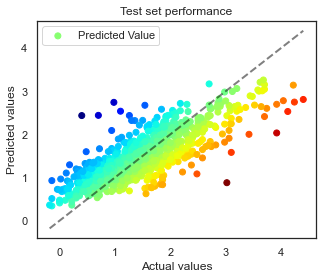


Regression: RandomForestRegressor
Featuriser:  ElementProperties

Best parameters:  {'max_depth': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}

Train RMSE:  0.43862950795903155  eV / unit cell
Train MAE:  0.1349130449566592  eV / unit cell
Train r^2:  0.9321026980104394

Test RMSE:  0.42324277069675287  eV / unit cell
Test MAE:  0.3162497917493445  eV / unit cell
Test r^2:  0.6451452896512315 



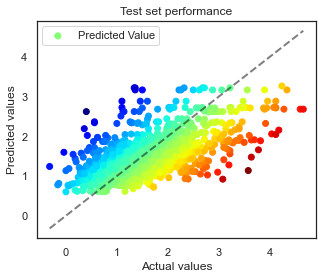


Regression: RandomForestRegressor
Featuriser:  ElementFractions

Best parameters:  {'max_depth': 60, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}

Train RMSE:  0.5712950506715903  eV / unit cell
Train MAE:  0.39333122471319426  eV / unit cell
Train r^2:  0.4925104984254881

Test RMSE:  0.5828568476192021  eV / unit cell
Test MAE:  0.43095790274835494  eV / unit cell
Test r^2:  0.3867821438509853 



In [21]:
rdmForestModel_ElementProperties = Modeller(rdmForest, rdmForest_paramGrid, "ElementProperties", load = True)
rdmForestModel_ElementFractions = Modeller(rdmForest, rdmForest_paramGrid, "ElementFractions", load = True)

### XGBoost

In [22]:
xgb = XGBRegressor(random_state=42)
xgb_paramGrid = {
    'n_estimators': [50, 100, 500, 1000],
    'max_depth': [5, 20, 60, 100],
    'learning_rate': [0.05, 0.1, 0.2, 0.5],
}


In [ ]:
# Dont run unless you want to spend a lot of time.

xgbModel_ElementProperties = Modeller(xgb, xgb_paramGrid, "ElementProperties")
xgbModel_ElementFractions = Modeller(xgb, xgb_paramGrid, "ElementFractions")

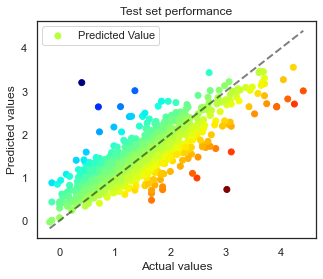


Regression: XGBRegressor
Featuriser:  ElementProperties

Best parameters:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}

Train RMSE:  0.4131763651583614  eV / unit cell
Train MAE:  0.09479185748195197  eV / unit cell
Train r^2:  0.9679033977010852

Test RMSE:  0.3982010174555426  eV / unit cell
Test MAE:  0.287229085045089  eV / unit cell
Test r^2:  0.6858940178327706 



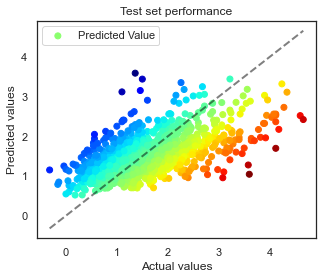


Regression: XGBRegressor
Featuriser:  ElementFractions

Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Train RMSE:  0.5787757057088779  eV / unit cell
Train MAE:  0.37654644346986493  eV / unit cell
Train r^2:  0.558019703282284

Test RMSE:  0.5859960577767434  eV / unit cell
Test MAE:  0.43855502256870266  eV / unit cell
Test r^2:  0.3801588924815634 



In [23]:
xgbModel_ElementProperties = Modeller(xgb, xgb_paramGrid, "ElementProperties", load = True)
xgbModel_ElementFractions = Modeller(xgb, xgb_paramGrid, "ElementFractions", load = True)

### k-Nearest neibors 

In [24]:
knn = KNeighborsRegressor()
knn_paramGrid = {
    'n_neighbors': [2, 4, 6, 8],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

In [ ]:
# Dont run unless you want to spend a lot of time.

knnModel_ElementProperties = Modeller(knn, knn_paramGrid, "ElementProperties")
knnModel_ElementFractions = Modeller(knn, knn_paramGrid, "ElementFractions")

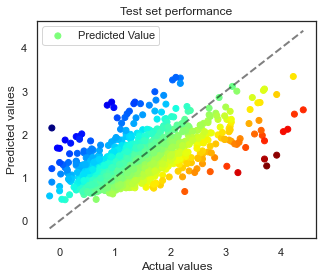


Regression: KNeighborsRegressor
Featuriser:  ElementProperties

Best parameters:  {'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'uniform'}

Train RMSE:  0.5593904759929869  eV / unit cell
Train MAE:  0.3630651693667158  eV / unit cell
Train r^2:  0.5219634114135473

Test RMSE:  0.5636442113923308  eV / unit cell
Test MAE:  0.41943513745704464  eV / unit cell
Test r^2:  0.37066544363629594 



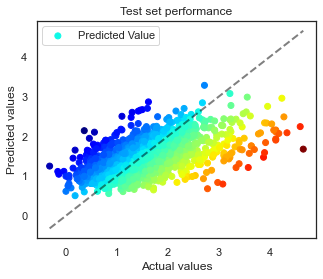


Regression: KNeighborsRegressor
Featuriser:  ElementFractions

Best parameters:  {'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'uniform'}

Train RMSE:  0.6105410951159173  eV / unit cell
Train MAE:  0.4072314285714286  eV / unit cell
Train r^2:  0.45630061391436216

Test RMSE:  0.6292375180857119  eV / unit cell
Test MAE:  0.47293833333333335  eV / unit cell
Test r^2:  0.28530588650651334 



In [25]:
knnModel_ElementProperties = Modeller(knn, knn_paramGrid, "ElementProperties", load = True)
knnModel_ElementFractions = Modeller(knn, knn_paramGrid, "ElementFractions", load = True)

### Suport Vector Machine

In [26]:
svr = SVR()
svr_paramGrid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'C': [0.5, 1, 2, 5]
}

In [ ]:
# Dont run unless you want to spend a lot of time.

svrModel_ElementProperties = Modeller(svr, svr_paramGrid, "ElementProperties")
svrModel_ElementFractions = Modeller(svr, svr_paramGrid, "ElementFractions")

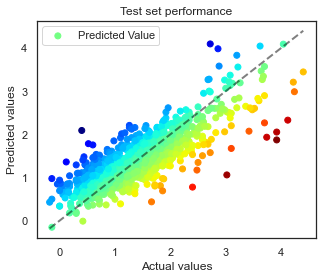


Regression: SVR
Featuriser:  ElementProperties

Best parameters:  {'C': 5, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

Train RMSE:  0.4265014634078922  eV / unit cell
Train MAE:  0.26901821909808965  eV / unit cell
Train r^2:  0.7122217705476093

Test RMSE:  0.4056290148738154  eV / unit cell
Test MAE:  0.2992542966414043  eV / unit cell
Test r^2:  0.674066123143535 



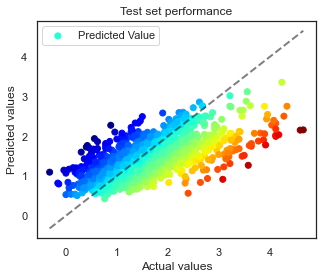


Regression: SVR
Featuriser:  ElementFractions

Best parameters:  {'C': 0.5, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Train RMSE:  0.5661577835653561  eV / unit cell
Train MAE:  0.3667853650702474  eV / unit cell
Train r^2:  0.49149376579330706

Test RMSE:  0.5752829140190622  eV / unit cell
Test MAE:  0.414828150250324  eV / unit cell
Test r^2:  0.40261551717843214 



In [27]:
svrModel_ElementProperties = Modeller(svr, svr_paramGrid, "ElementProperties", load = True)
svrModel_ElementFractions = Modeller(svr, svr_paramGrid, "ElementFractions", load = True)

### Decsion Tree

In [28]:
tree = DecisionTreeRegressor(random_state=42)
tree_paramGrid = {
    'max_depth': [5, 20, 60, 100],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [2, 5, 10, 15],
}

In [ ]:
# Dont run unless you want to spend a lot of time.

treeModel_ElementProperties = Modeller(tree, tree_paramGrid, "ElementProperties")
treeModel_ElementFractions = Modeller(tree, tree_paramGrid, "ElementFractions")

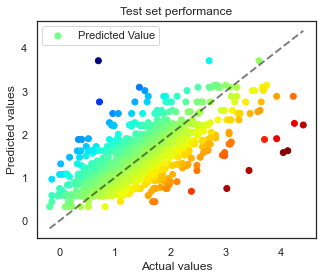


Regression: DecisionTreeRegressor
Featuriser:  ElementProperties

Best parameters:  {'max_depth': 20, 'min_samples_leaf': 15, 'min_samples_split': 2}

Train RMSE:  0.5471229710807001  eV / unit cell
Train MAE:  0.29070858370584257  eV / unit cell
Train r^2:  0.7025551726399704

Test RMSE:  0.5218525285660628  eV / unit cell
Test MAE:  0.38443279132591923  eV / unit cell
Test r^2:  0.46053029485500163 



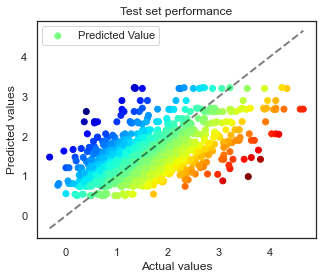


Regression: DecisionTreeRegressor
Featuriser:  ElementFractions

Best parameters:  {'max_depth': 60, 'min_samples_leaf': 10, 'min_samples_split': 2}

Train RMSE:  0.5934526687405155  eV / unit cell
Train MAE:  0.41096376523866446  eV / unit cell
Train r^2:  0.4574320429301961

Test RMSE:  0.6086036951886313  eV / unit cell
Test MAE:  0.45110498882450095  eV / unit cell
Test r^2:  0.33140956978952396 



In [29]:
treeModel_ElementProperties = Modeller(tree, tree_paramGrid, "ElementProperties", load = True)
treeModel_ElementFractions = Modeller(tree, tree_paramGrid, "ElementFractions", load = True)

In [30]:
# Create functions view the performance of the models, both as a table and as a chart.

def StatsDf(modelList):

    # Inputs: List of model objects
    # Objective: Create a dataframe of the performance metrics of the models
    # Outputs: Dataframe of the performance metrics of the models

    modelList_names = [model.name for model in modelList] # Extract the names of the models
    modelList_train_rmse = [model.train_rmse.mean() for model in modelList] # Extract the mean train RMSE of the models
    modelList_train_mae = [model.train_mae for model in modelList] # Extract the train MAE of the models
    modelList_train_r2 = [model.train_r2 for model in modelList] # Extract the train R^2 score of the models
    modelList_test_rmse = [model.test_rmse.mean() for model in modelList] # Extract the mean test RMSE of the models
    modelList_test_mae = [model.test_mae for model in modelList] # Extract the test MAE of the models
    modelList_test_r2 = [model.test_r2 for model in modelList] # Extract the test R^2 score of the models

    stats = pd.DataFrame({'Regressors': modelList_names,
                        'Train RMSE': modelList_train_rmse,
                        'Train MAE': modelList_train_mae,
                        'Train r2': modelList_train_r2,
                        'Test RMSE': modelList_test_rmse,
                        'Test MAE': modelList_test_mae,
                        'Test r2': modelList_test_r2})

    return stats

def plotGroupedChart(df, featuriser):

    # Inputs: Dataframe of the performance metrics of the models, featuriser
    # Objective: Plot a grouped bar chart of the performance metrics of the models
    # Outputs: None

    plt.figure(figsize=(9, 6))
    sns.barplot(x="Metric", y="Value" , saturation = 1, edgecolor = "black",  hue="Regressors", palette = "hls",
                data=pd.melt(df, id_vars=["Regressors"], var_name="Metric", value_name="Value"))
    plt.title("Performance Metrics for " + featuriser + " Featuriser")
    plt.xlabel("Metrics")
    plt.ylabel("Metric Value (eV / unit cell)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [31]:
# Create lists of the model objects for each featuriser

modelList_ElementProperties = [rdmForestModel_ElementProperties, xgbModel_ElementProperties, knnModel_ElementProperties, svrModel_ElementProperties, treeModel_ElementProperties]
modelList_ElementFractions = [rdmForestModel_ElementFractions, xgbModel_ElementFractions, knnModel_ElementFractions, svrModel_ElementFractions, treeModel_ElementFractions]

In [32]:
stats_ElementProperties = StatsDf(modelList_ElementProperties) # Create the dataframe of the performance metrics of the models
stats_ElementProperties # Display the dataframe

,Regressors,Train RMSE,Train MAE,Train r2,Test RMSE,Test MAE,Test r2
0,RandomForest,0.438630,0.134913,0.932103,0.423243,0.316250,0.645145
1,XGB,0.413176,0.094792,0.967903,0.398201,0.287229,0.685894
2,KNeighbors,0.559390,0.363065,0.521963,0.563644,0.419435,0.370665
3,SVR,0.426501,0.269018,0.712222,0.405629,0.299254,0.674066
4,DecisionTree,0.547123,0.290709,0.702555,0.521853,0.384433,0.460530


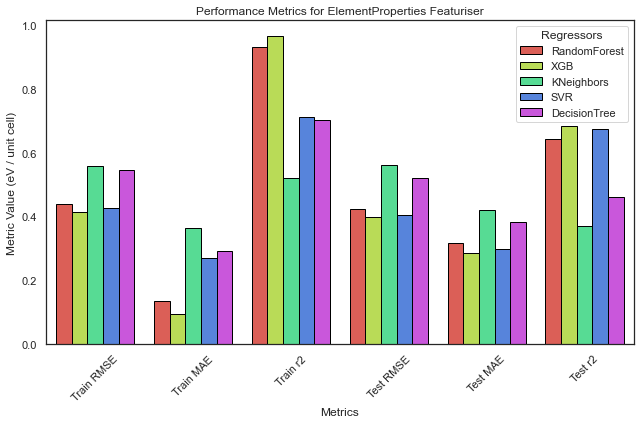

In [33]:
plotGroupedChart(stats_ElementProperties, featuriser="ElementProperties") # Plot a grouped bar chart of the performance metrics of the models

In [34]:
stats_ElementFractions = StatsDf(modelList_ElementFractions) # Create the dataframe of the performance metrics of the models
stats_ElementFractions # Display the dataframe

,Regressors,Train RMSE,Train MAE,Train r2,Test RMSE,Test MAE,Test r2
0,RandomForest,0.571295,0.393331,0.492510,0.582857,0.430958,0.386782
1,XGB,0.578776,0.376546,0.558020,0.585996,0.438555,0.380159
2,KNeighbors,0.610541,0.407231,0.456301,0.629238,0.472938,0.285306
3,SVR,0.566158,0.366785,0.491494,0.575283,0.414828,0.402616
4,DecisionTree,0.593453,0.410964,0.457432,0.608604,0.451105,0.331410


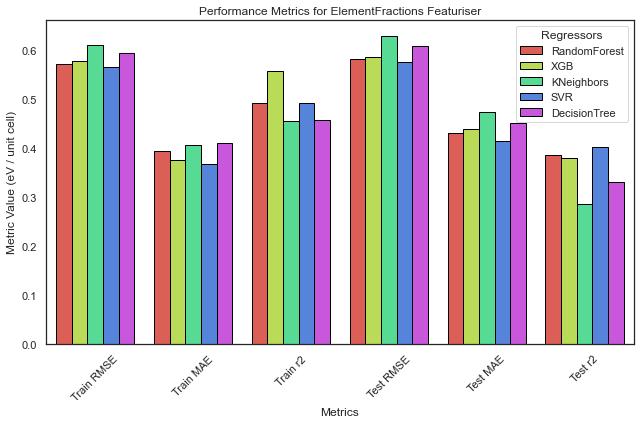

In [35]:
plotGroupedChart(stats_ElementFractions, featuriser="ElementFractions") # Plot a grouped bar chart of the performance metrics of the models

- From the performance metrics of the models, it is clear that...
- The ElementProperties featuriser performs better than the ElementFractions featuriser for all the models.
    - Intiuatively this would make sense, as the ElementProperties featuriser contains many features which are more closely correlated to the formation energy, more so than the fraction of elements in the perovskite. Some of which include first ionisation energy, electronegativity, and atomic number
- The best model is the XGBoost model with the ElementProperties featuriser, as it has the
    - Lowest test RMSE at 0.398 eV / unit cell
    - Lowest test MAE at 0.0287 eV / unit cell
    - Highest test R^2 score at 0.685
    - Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}

## Auto Machine Learning (FLAML)
- Going through each possible regressor and increasing the search space of my hyperparameter grid to find the best possible model for my dataset would take an extremely long time.
- We can perform this all automatically using "Auto machine learning".
- I will be using a libary called "FLAML", or "Fast Lightweight AutoML", created by Microsoft
- It is an auto machine learning library designed to automate the process of model selection, hyperparameter optimization, and feature engineering.
- It intelligently selects the best model from a wide range of options and then optimizes its hyperparameters using techniques like Bayesian optimization and adaptive resource allocation.
- Therefore it provides a user-friendly and efficient solution for building high-performing machine learning models with minimal manual intervention, making it ideal for users looking to quickly prototype and deploy models.
- Libaries such as these are useful in finding a good model quickly, and thereafter you can manually inspect and tune the model accordingly to better fit your data.
- Note: I tried using "Automatminer", "auto scikit learn", and "TPOT" however ran into numerous compatibility errors.

In [36]:
# Class to create and process machine learning pipeline for regressors. This time, using the AutoML library FLAML

class AutoMLModel:
    def __init__(self, df, featuriser):
        self.df = df
        self.featuriser = featuriser
        
        self.automl = AutoML() # Create the AutoML object

        # Set the AutoML settings
        self.automl_settings = {
            "time_budget": -1,  # in seconds. -1 means no time limit. 
            "metric": 'mse', # The metric to optimise
            "task": 'regression', # The type of task
            "verbose": 2 
            }

    def test_train_split(self): # Split the dataset into training and testing sets
        features_to_drop = ['structure','composition', 'e_form'] # Drop the structure and composition columns
        feature_cols = [col for col in list(self.df.columns) if col not in features_to_drop] # Extract the feature columns
        
        X = self.df[feature_cols]
        y = self.df['e_form']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Split the dataset into training and testing sets   

    def fit(self): # Fit the model
        self.automl.fit(self.X_train, self.y_train, **self.automl_settings) # Fit the model using the AutoML settings
        self.best_model = self.automl.model.estimator # Extract the best model as an object
        self.name = "automl_" + self.automl.best_estimator + "_" + self.featuriser # Extract the name of the best model
        self.best_params = self.automl.best_config # Extract the best hyperparameters

        self.cv_scores = -cross_val_score(self.best_model, self.X_train, self.y_train, cv=10, scoring='neg_mean_squared_error') # Perform cross-validation
        self.train_rmse = np.sqrt(self.cv_scores) # Calculate the RMSE
        self.train_mae = mean_absolute_error(self.y_train, self.automl.predict(self.X_train)).mean() # Calculate the MAE
        self.train_r2 = self.automl.score(self.X_train, self.y_train).mean() # Calculate the R^2 score

    def save_model(self): # Save the model. These will be saved in the same directory as the notebook
        joblib.dump(self.automl, 'automl_' + self.featuriser + '_model.pkl')
        np.save('automl_' + self.featuriser +  '_train_rmse.npy', self.train_rmse)
        np.save('automl_' + self.featuriser +  '_train_mae.npy', self.train_mae)
        np.save('automl_' + self.featuriser +  '_train_r2.npy', self.train_r2)
        
    def load_model(self): # Load the model. Ensure the model files is in the same directory as the notebook
        self.automl = joblib.load('automl_' + self.featuriser + '_model.pkl')
        self.best_model = self.automl.model.estimator
        self.name = "automl_" + self.automl.best_estimator + "_" + self.featuriser
        self.best_params = self.automl.best_config

        self.train_rmse = np.load('automl_' + self.featuriser +  '_train_rmse.npy')
        self.train_mae = np.load('automl_' + self.featuriser +  '_train_mae.npy')
        self.train_mae = self.train_mae.mean()
        self.train_r2 = np.load('automl_' + self.featuriser +  '_train_r2.npy')
        self.train_r2 = self.train_r2.mean()

    def predict(self): # Predict the target variable
        self.test_preds = self.automl.predict(self.X_test)
        self.test_r2 = r2_score(self.y_test, self.test_preds) # Calculate the R^2 score
        self.test_rmse = np.sqrt(mean_squared_error(self.y_test, self.test_preds)) # Calculate the RMSE
        self.test_mae = mean_absolute_error(self.y_test, self.test_preds) # Calculate the MAE

    def plot(self): # Plot the performance of the model
        plt.figure(figsize=(5, 4))
        plt.scatter(self.y_test, self.test_preds, label="Predicted Value", c=self.y_test - self.test_preds, cmap='jet') # Plot the predicted values
        plt.plot([min(self.y_test), max(self.y_test)], [min(self.y_test), max(self.y_test)], 'k--', lw=2, alpha=0.5) # Plot a line whih represents the perfect prediction
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        plt.title("Test set performance")
        plt.legend()
        plt.show()

In [37]:
# Create a function which will use the class above and run each method / step in the machine learning pipeline

def AutoML_Modeller(featuriser, load = False):

    # Inputs: Featuriser, load model (default is False. Use when first creating model. If True, the model will be loaded instead of trained)
    # Objective: Use the "AutoMLModel" class and run each method / step in the machine learning pipeline.
    # Outputs: Model object

    # Choose the featuriser
    if featuriser == "ElementProperties":
        df = df_ElementProperties
    elif featuriser == "ElementFractions":
        df = df_ElementFractions

    model = AutoMLModel(df, featuriser) # Create the model object
    model.test_train_split() # Split the dataset into training and testing sets

    if load == False:
        model.fit() # Fit the model
        model.save_model() # Save the model

    elif load == True:
        model.load_model() # Load the model

    model.predict() # Predict the target variable
    model.plot() # Plot the performance of the model

    # Print the statistics
    print("\nRegression: " + re.search(r"(\w+)", str(model.best_model)).group(0))
    print("Featuriser: ", featuriser)
    print("\nBest parameters: ", model.best_params)

    print("\nTrain RMSE: ", model.train_rmse.mean(), " eV / unit cell")
    print("Train MAE: ", model.train_mae, " eV / unit cell")
    print("Train r^2: ", model.train_r2)

    print("\nTest RMSE: ", model.test_rmse, " eV / unit cell")
    print("Test MAE: ", model.test_mae, " eV / unit cell")
    print("Test r^2: ", model.test_r2, "\n")

    return model

# **NOTE**
- The cells and functions without "load = True" will create the machine learning pipeline and model for the first time, and therefore will take a very long time time run.
- For ease and time sake, I have done this in my own time, and created a function and method to save this pipeline, which I can load back quickly
- Therefore I have ran cells with load set to True

In [ ]:
# Dont run unless you want to spend a lot of time.

AutoML_ElementProperties = AutoML_Modeller(featuriser="ElementProperties")

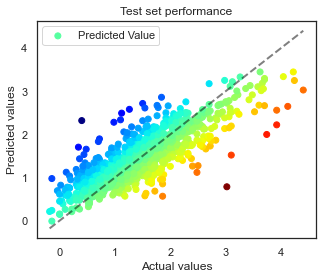


Regression: XGBRegressor
Featuriser:  ElementProperties

Best parameters:  {'n_estimators': 4923, 'max_depth': 12, 'min_child_weight': 0.7625732991776795, 'learning_rate': 0.009239549681857523, 'subsample': 0.8193164619615052, 'colsample_bylevel': 0.7785754297307862, 'colsample_bytree': 0.788491073979525, 'reg_alpha': 0.002282749364196872, 'reg_lambda': 131.2194560716439}

Train RMSE:  0.4140462171690474  eV / unit cell
Train MAE:  0.028097343687544164  eV / unit cell
Train r^2:  0.9918977882225775

Test RMSE:  0.40131088674864623  eV / unit cell
Test MAE:  0.2934262534393849  eV / unit cell
Test r^2:  0.6809686513857153 



In [38]:
AutoML_ElementProperties = AutoML_Modeller(featuriser="ElementProperties", load = True)

In [ ]:
# Dont run unless you want to spend a lot of time.

AutoML_ElementFractions = AutoML_Modeller(featuriser="ElementFractions")

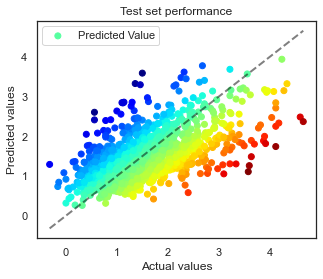


Regression: XGBRegressor
Featuriser:  ElementFractions

Best parameters:  {'n_estimators': 4923, 'max_depth': 12, 'min_child_weight': 0.7625732991776795, 'learning_rate': 0.009239549681857523, 'subsample': 0.8193164619615052, 'colsample_bylevel': 0.7785754297307862, 'colsample_bytree': 0.788491073979525, 'reg_alpha': 0.002282749364196872, 'reg_lambda': 131.2194560716439}

Train RMSE:  0.5810666352504406  eV / unit cell
Train MAE:  0.3070475865098408  eV / unit cell
Train r^2:  0.6901865418313086

Test RMSE:  0.598391419134023  eV / unit cell
Test MAE:  0.4440864865446091  eV / unit cell
Test r^2:  0.3536590077317203 



In [39]:
AutoML_ElementFractions = AutoML_Modeller(featuriser="ElementFractions", load = True)

In [40]:
# Create a list of the model objects for each featuriser
stats_AutoML_ElementProperties = StatsDf([AutoML_ElementProperties])
stats_AutoML_ElementFractions = StatsDf([AutoML_ElementFractions])

# Create a dataframe of the performance metrics of the models
stats_AutoML = pd.concat([stats_AutoML_ElementProperties, stats_AutoML_ElementFractions])
stats_AutoML.set_index('Regressors', inplace=True)
stats_AutoML.reset_index(inplace=True)
stats_AutoML

,Regressors,Train RMSE,Train MAE,Train r2,Test RMSE,Test MAE,Test r2
0,automl_xgb_limitdepth_ElementProperties,0.414046,0.028097,0.991898,0.401311,0.293426,0.680969
1,automl_xgb_limitdepth_ElementFractions,0.581067,0.307048,0.690187,0.598391,0.444086,0.353659


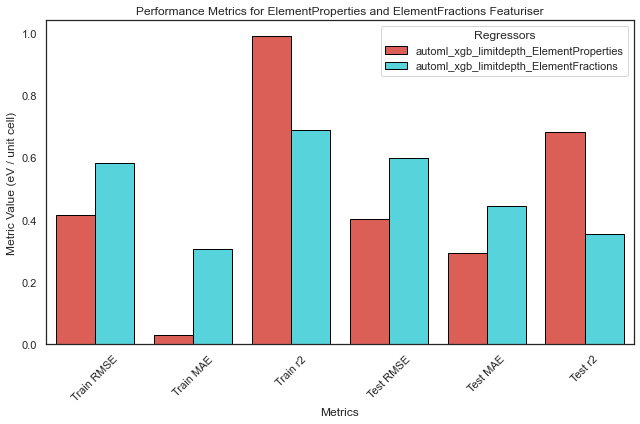

In [41]:
plotGroupedChart(stats_AutoML, featuriser="ElementProperties and ElementFractions") # Plot a grouped bar chart of the performance metrics of the models

- From the performance metrics of the models, it is clear that...
- The ElementProperties featuriser performs better than the ElementFractions featuriser for all the models for the same reasons explained before.
- The best model is the XGBoost limit depth model with the ElementProperties featuriser, as it has the
    - Lowest test RMSE at 0.401 eV / unit cell
    - Lowest test MAE at 0.293 eV / unit cell
    - Highest test R^2 score at 0.681
    - Hyperparameters: {'n_estimators': 4923, 'max_depth': 12, 'min_child_weight': 0.7625732991776795, 'learning_rate': 0.009239549681857523, 'subsample': 0.8193164619615052, 'colsample_bylevel': 0.7785754297307862, 'colsample_bytree': 0.788491073979525, 'reg_alpha': 0.002282749364196872, 'reg_lambda': 131.2194560716439}

# Auto Keras
- We can also solve this regression problem via deep learning and creating a dense neural network, similar to the convulated neural networks ranking highly on the matminer leaderbaord.
- Creating a densely connected neural network, with each dense layer, activation function, and drop out hyperparameter tunned finely however will take an extremely long time.
- Therefore we use a libray called "Auto Keras" which will automatically create and tune a dense neural network for us.
- This could be used to quickly create a good dense network, which can then be fine tuned manually later.

In [42]:
# Class to create and process machine learning pipeline for regressors. This time, using the AutoKeras library


class AutoKeras:
    def __init__(self, df, featuriser):
        self.df = df
        self.featuriser = featuriser
        self.name = 'autokeras_' + self.featuriser
        
        # Set the AutoKeras settings
        self.reg = ak.StructuredDataRegressor(seed = 42, max_trials = 100, overwrite=True, objective = 'mean_squared_error',
                                              directory= r'C:\autokeras', project_name = self.name, metrics=['mean_squared_error', RSquare()])

    def test_train_split(self): # Split the dataset into training and testing sets
        features_to_drop = ['structure','composition', 'e_form'] # Drop the structure and composition columns
        feature_cols = [col for col in list(self.df.columns) if col not in features_to_drop] # Extract the feature columns
        
        X = self.df[feature_cols]
        y = self.df['e_form']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Split the dataset into training and testing sets

    def fit(self): # Fit the model
        self.reg.fit(self.X_train, self.y_train, epochs=1000, validation_split=0.15) # Fit the model
        self.model = self.reg.export_model()
        self.model.evaluate(self.X_train, self.y_train) # Evaluate the model

        self.evaluate = self.model.evaluate(self.X_train, self.y_train) # Evaluate the model
        self.train_rmse = np.sqrt(self.evaluate[1]) # Calculate the RMSE
        self.train_mae = mean_absolute_error(self.y_train, self.model.predict(self.X_train)) # Calculate the MAE
        self.train_r2 = self.evaluate[2] # Calculate the R^2 score

    def save_model(self): # Save the model. These will be saved in the same directory as the notebook
        self.model.save(self.name, save_format="tf")
        
    def loadModel(self): # Load the model. Ensure the model files is in the same directory as the notebook
        self.model = load_model(self.name, custom_objects=ak.CUSTOM_OBJECTS)
        self.evaluate = self.model.evaluate(self.X_train, self.y_train)
        self.train_rmse = np.sqrt(self.evaluate[1])
        self.train_mae = mean_absolute_error(self.y_train, self.model.predict(self.X_train))
        self.train_r2 = self.evaluate[2]

    def predict(self): # Predict the target variable
        self.test_preds= self.model.predict(self.X_test) 
        self.test_r2 = r2_score(self.y_test, self.test_preds) # Calculate the R^2 score
        self.test_rmse = np.sqrt(mean_squared_error(self.y_test, self.test_preds)) # Calculate the RMSE
        self.test_mae = mean_absolute_error(self.y_test, self.test_preds) # Calculate the MAE

    def plot(self): # Plot the performance of the model
        plt.figure(figsize=(5, 4))
        plt.scatter(self.y_test, self.test_preds, label="Predicted Value", c=self.y_test - self.test_preds.reshape(-1,), cmap='jet') # Plot the predicted values
        plt.plot([min(self.y_test), max(self.y_test)], [min(self.y_test), max(self.y_test)], 'k--', lw=2, alpha=0.5) # Plot a line whih represents the perfect prediction
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        plt.title("Test set performance")
        plt.legend()
        plt.show()
    
    def summary(self): # Print the structure of the dense neural network
        self.model.summary()

In [43]:
# Create a function which will use the class above and run each method / step in the machine learning pipeline

def AutoKeras_Modeller(featuriser, load = False):

    # Inputs: Featuriser, load model (default is False. Use when first creating model. If True, the model will be loaded instead of trained)
    # Objective: Use the "AutoKeras" class and run each method / step in the machine learning pipeline.
    # Outputs: Model object

    if featuriser == "ElementProperties":
        df = df_ElementProperties
    elif featuriser == "ElementFractions":
        df = df_ElementFractions

    model = AutoKeras(df, featuriser) # Create the model object
    model.test_train_split() # Split the dataset into training and testing sets

    if load == False:
        model.fit() # Fit the model
        model.save_model() # Save the model

    elif load == True:
        model.loadModel() # Load the model

    model.predict() # Predict the target variable
    model.plot() # Plot the performance of the model
    
    # Print the statistics
    print("\nDense Neural Network")
    print("Featuriser: ", featuriser)

    print("\nTrain RMSE: ", model.train_rmse, " eV / unit cell")
    print("Train MAE: ", model.train_mae, " eV / unit cell")
    print("Train r^2: ", model.train_r2)

    print("\nTest RMSE: ", model.test_rmse, " eV / unit cell")
    print("Test MAE: ", model.test_mae, " eV / unit cell")
    print("Test r^2: ", model.test_r2, "\n")

    return model

In [ ]:
# Dont run unless you want to spend a lot of time.

AutoKeras_ElementProperties = AutoKeras_Modeller(featuriser="ElementProperties")

37/37 [==============================] - 0s 4ms/step


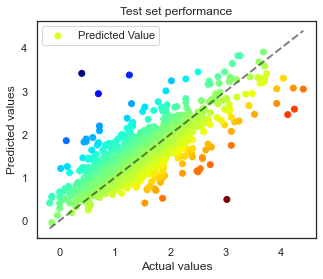


Dense Neural Network
Featuriser:  ElementProperties

Train RMSE:  0.06773507258112109  eV / unit cell
Train MAE:  0.0444702062980767  eV / unit cell
Train r^2:  0.9908745884895325

Test RMSE:  0.442523551572154  eV / unit cell
Test MAE:  0.31921900900573663  eV / unit cell
Test r^2:  0.6120781382479199 



In [44]:
AutoKeras_ElementProperties = AutoKeras_Modeller(featuriser="ElementProperties", load = True)

In [45]:
AutoKeras_ElementProperties.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 83)]              0         
                                                                 
 multi_category_encoding (M  (None, 83)                0         
 ultiCategoryEncoding)                                           
                                                                 
 normalization (Normalizati  (None, 83)                167       
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                5376      
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1024)              66560 

In [ ]:
# Dont run unless you want to spend a lot of time.

AutoKeras_ElementFractions = AutoKeras_Modeller(featuriser="ElementFractions")

47/47 [==============================] - 0s 2ms/step


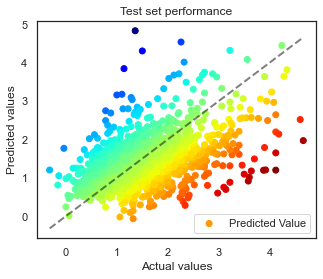


Dense Neural Network
Featuriser:  ElementFractions

Train RMSE:  0.3642595715518644  eV / unit cell
Train MAE:  0.25554709093809125  eV / unit cell
Train r^2:  0.757407009601593

Test RMSE:  0.7020251883681898  eV / unit cell
Test MAE:  0.5167182326428096  eV / unit cell
Test r^2:  0.11039671952550001 



In [46]:
AutoKeras_ElementFractions = AutoKeras_Modeller(featuriser="ElementFractions", load = True)

In [47]:
AutoKeras_ElementFractions.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56)]              0         
                                                                 
 multi_category_encoding (M  (None, 56)                0         
 ultiCategoryEncoding)                                           
                                                                 
 normalization (Normalizati  (None, 56)                113       
 on)                                                             
                                                                 
 dense (Dense)               (None, 256)               14592     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                             

In [48]:
# Create a list of the model objects for each featuriser
stats_AutoKeras_ElementProperties = StatsDf([AutoKeras_ElementProperties])
stats_AutoKeras_ElementFractions = StatsDf([AutoKeras_ElementFractions])

# Create a dataframe of the performance metrics of the models
stats_AutoKeras = pd.concat([stats_AutoKeras_ElementProperties, stats_AutoKeras_ElementFractions])
stats_AutoKeras.set_index('Regressors', inplace=True)
stats_AutoKeras.reset_index(inplace=True)
stats_AutoKeras

,Regressors,Train RMSE,Train MAE,Train r2,Test RMSE,Test MAE,Test r2
0,autokeras_ElementProperties,0.067735,0.044470,0.990875,0.442524,0.319219,0.612078
1,autokeras_ElementFractions,0.364260,0.255547,0.757407,0.702025,0.516718,0.110397


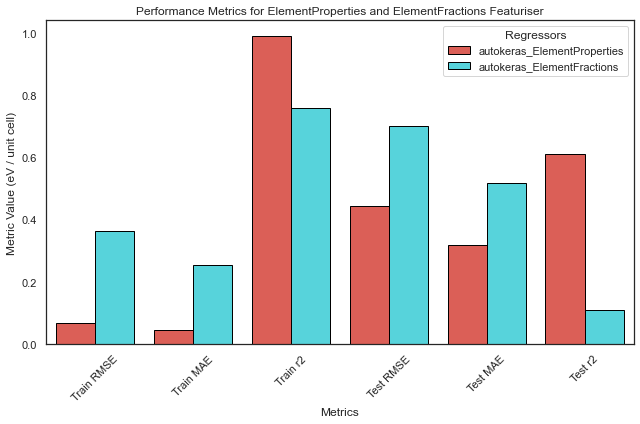

In [49]:
plotGroupedChart(stats_AutoKeras, featuriser="ElementProperties and ElementFractions")

- From the performance metrics of the models, it is clear that...
- The ElementProperties featuriser performs better than the ElementFractions featuriser for all the models for the same reasons explained before.
- The dense neural network is overfitted. This can be seen by the fact that the RMSE and MAE are extremely low during the training, however on the test set are much higher.
- This is probably due to no cross validation step, which would split the training data itself into multiple folds for validation.
- We could correct this by manually adding a cross validation step and tuning the hyperparameters of our dense neural network manually and more efficently, however due to time constraints this will not be performed.

# Model Comparison

In [50]:
# Create a list of the model objects for each featuriser
BestModelsList = [xgbModel_ElementProperties, AutoML_ElementProperties, AutoKeras_ElementProperties]

# Create a dataframe of the performance metrics of the models
stats_BestModels = StatsDf(BestModelsList)
stats_BestModels

,Regressors,Train RMSE,Train MAE,Train r2,Test RMSE,Test MAE,Test r2
0,XGB,0.413176,0.094792,0.967903,0.398201,0.287229,0.685894
1,automl_xgb_limitdepth_ElementProperties,0.414046,0.028097,0.991898,0.401311,0.293426,0.680969
2,autokeras_ElementProperties,0.067735,0.044470,0.990875,0.442524,0.319219,0.612078


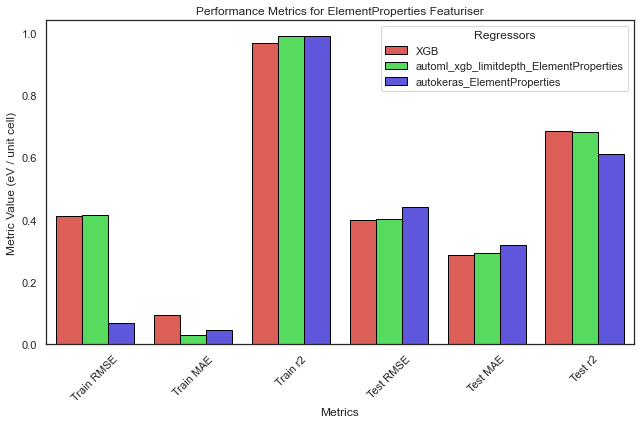

In [51]:
plotGroupedChart(stats_BestModels, featuriser="ElementProperties") # Plot a grouped bar chart of the performance metrics of the models

- We can now visulise each of our models and compare model performance and statistics
- We can see XGB with our hyperparameter grid performs the best, due to the low RMSE, MAE and high r2 during testing.

# Model Choice
- Display our best model, which is XGB, aswell as its stats and feature importance

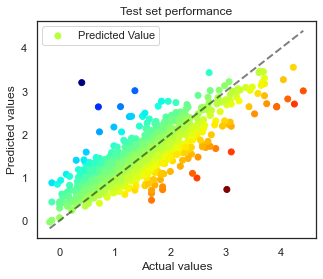


Regression: XGB
Featuriser:  ElementProperties

Best parameters:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}

Train RMSE:  0.4131763651583614  eV / unit cell
Train MAE:  0.09479185748195197  eV / unit cell
Train r^2:  0.9679033977010852

Test RMSE:  0.3982010174555426  eV / unit cell
Test MAE:  0.287229085045089  eV / unit cell
Test r^2:  0.6858940178327706 



In [52]:
xgbModel_ElementProperties.plot()

print("\nRegression: " + re.search(r"(\w+)", str(xgbModel_ElementProperties.name)).group(0))
print("Featuriser: ", xgbModel_ElementProperties.featuriser)
print("\nBest parameters: ", xgbModel_ElementProperties.best_params)

print("\nTrain RMSE: ", xgbModel_ElementProperties.train_rmse.mean(), " eV / unit cell")
print("Train MAE: ", xgbModel_ElementProperties.train_mae, " eV / unit cell")
print("Train r^2: ", xgbModel_ElementProperties.train_r2)

print("\nTest RMSE: ", xgbModel_ElementProperties.test_rmse, " eV / unit cell")
print("Test MAE: ", xgbModel_ElementProperties.test_mae, " eV / unit cell")
print("Test r^2: ", xgbModel_ElementProperties.test_r2, "\n")

In [53]:
stats_xgb = stats_BestModels.loc[stats_BestModels['Regressors'] == 'XGB']
stats_xgb

,Regressors,Train RMSE,Train MAE,Train r2,Test RMSE,Test MAE,Test r2
0,XGB,0.413176,0.094792,0.967903,0.398201,0.287229,0.685894


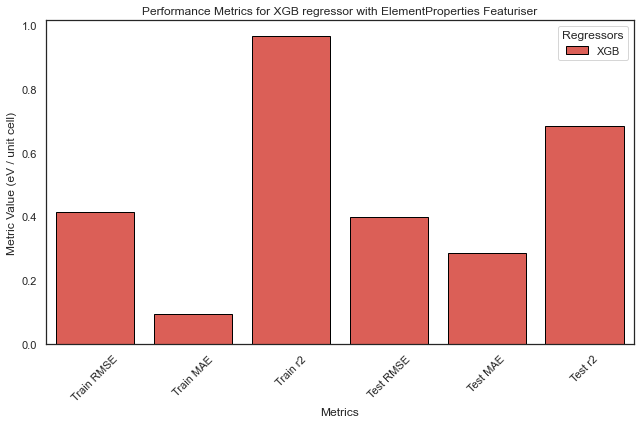

In [54]:
plotGroupedChart(stats_xgb, featuriser="XGB regressor with ElementProperties")

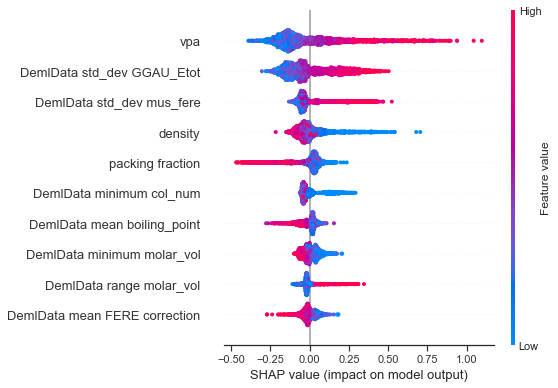

In [55]:
# We can use the SHAP library to explain the predictions of the XGB model, and to understand the importance of the features in the model.

explainer = shap.TreeExplainer(xgbModel_ElementProperties.best_model) # Create the explainer object
shap_values = explainer.shap_values(xgbModel_ElementProperties.X_train) # Calculate the SHAP values

shap.summary_plot(shap_values, xgbModel_ElementProperties.X_train, max_display=10) # Plot the SHAP summary plot, showing the feature importance of the top 10 features

- A SHAP plot is useful in giving us an interable feature value importance for a "forest" like algorithms such as XGB
- Values with a higher "SHAP value" postively contribute to the prediction, meaning the predication will be closer to the actual.
- The color scale denotes feature magnitude.
- Therefore, we can see that:
    - Higher VPA values postively impact our prediction, while lower VPA values negatively impact our prediction, but this impact is less than the postive impact of higher values.
    - The "bulging" indicates we have more low value VPA's than high value VPA's in our dataset.
- This may be useful for further enchaning our model, by narrowing down our input features to only those which postively impact the prediction

## Large Language Model (LLM) usage declaration

You should acknowledge any use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-3, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

In [ ]:
'''
Generative tools used which assisted in the completion of the project:
- Github Copilot (code snippets, suggestions, and completions)
- Chat GPT (code snippets, suggestions, genreal inforamtion)

Other tools used:
- Stackoverflow (debugging, help with code errors)

- No major limitations/biases were identified during the project.
- I ensured I understood the unlying code I was using, and I did not copy and paste code without understanding it.

'''

## ☘️ Final word

Good luck building your own model! I hope that you enjoyed the course and exercises. Dive deeper into the aspects that caught your interest. A useful starting point may be the [Resources](https://aronwalsh.github.io/MLforMaterials/Resources.html) page. 

Remember that submission is on Blackboard and this time you should upload the actual Juypter Notebook (`.ipynb` file), as well as your recorded narrated presentation (maximum 5 minutes; see guides on using [Zoom](https://www.youtube.com/watch?v=H9qhoAIzW3E) or [Powerpoint](https://www.youtube.com/watch?v=Y5dgwwa5XRA) for this purpose).